In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt


In [2]:
# Load the data: the Cats vs Dogs dataset
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  75.6M      0  0:00:10  0:00:10 --:--:-- 78.3M


In [5]:
!unzip -q kagglecatsanddogs_5340.zip


replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [7]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


In [8]:
image_size = (224, 224)
batch_size = 64

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


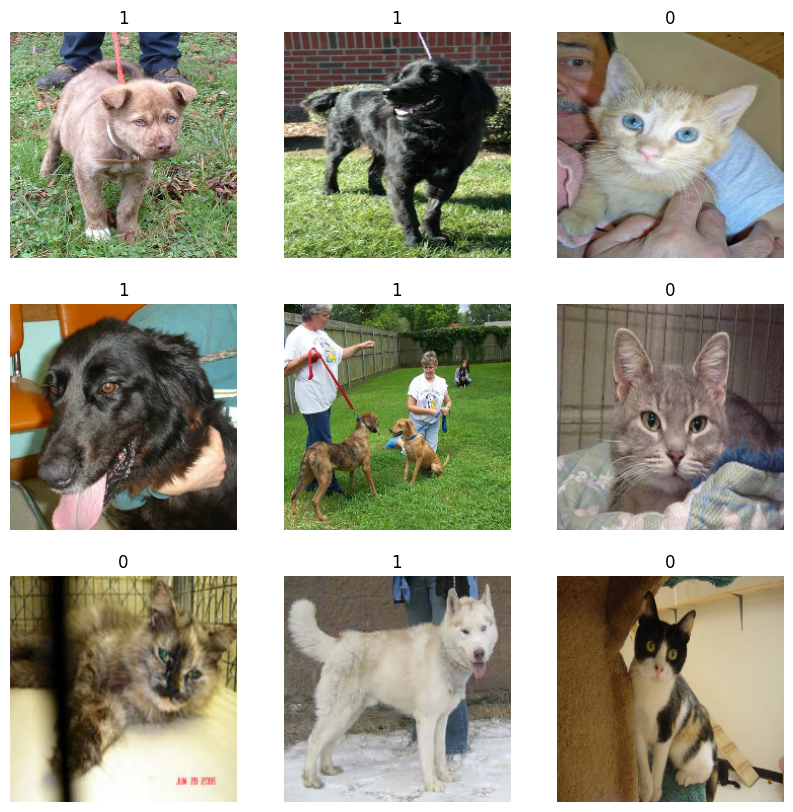

In [9]:
# Visualize the data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [10]:
base_model = keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = keras.Input(shape=(224, 224, 3))

# Pass the input through the base model
x = base_model(inputs, training=False)

# Add a pooling layer to reduce the dimensionality of the features
x = layers.GlobalAveragePooling2D()(x)

# Add a dense layer with 128 units and ReLU activation
x = layers.Dense(128, activation="relu")(x)

# Add a dropout layer to prevent overfitting
x = layers.Dropout(0.2)(x)

# Add the output layer with 2 units for the two classes (Cat and Dog)
outputs = layers.Dense(2, activation="softmax")(x)

# Create the model
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(train_ds, epochs=2, validation_data=val_ds)


Epoch 1/2
293/293 [==============================] - 318s 986ms/step - loss: 0.0343 - accuracy: 0.9882 - val_loss: 0.0233 - val_accuracy: 0.9923
Epoch 2/2
293/293 [==============================] - 250s 852ms/step - loss: 0.0153 - accuracy: 0.9957 - val_loss: 0.0253 - val_accuracy: 0.9910
